In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
warnings.filterwarnings("ignore")

In [29]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2015-01-01',end='2020-12-31')
JPM.describe()



,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1511.0
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.0
std,22.829644,23.042576,22.634188,22.824210,6.771181e+06,0.081388,0.0
min,44.681977,45.383560,41.570080,44.559067,3.324300e+06,0.000000,0.0
25%,56.433763,56.713369,56.017183,56.434134,1.114535e+07,0.000000,0.0
50%,86.894188,88.044232,85.913358,86.872887,1.377760e+07,0.000000,0.0
75%,99.336526,100.329615,98.336744,99.256760,1.772140e+07,0.000000,0.0
max,129.942675,131.580773,129.348236,131.047989,5.619230e+07,0.900000,0.0


In [30]:
# Elimino la colonna 'Stock Splits', poichè è una colonna contenente tutti zeri, è aggiungo la colonna relativa ai rendimenti del titolo
# che serve soltanto per l'analisi esplorativa
JPM = JPM.drop('Stock Splits', axis = 1)
JPM['Rendimenti'] = JPM['Open'].diff()
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Rendimenti
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1510.000000
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.045864
std,22.829644,23.042576,22.634188,22.824210,6.771181e+06,0.081388,1.505812
min,44.681977,45.383560,41.570080,44.559067,3.324300e+06,0.000000,-10.086370
25%,56.433763,56.713369,56.017183,56.434134,1.114535e+07,0.000000,-0.568304
50%,86.894188,88.044232,85.913358,86.872887,1.377760e+07,0.000000,0.064540
75%,99.336526,100.329615,98.336744,99.256760,1.772140e+07,0.000000,0.678129
max,129.942675,131.580773,129.348236,131.047989,5.619230e+07,0.900000,10.493415


In [ ]:
filter_row = JPM.index.to_series().between('2015-01-01', '2019-12-31')
test = JPM[filter_row == False]
train = JPM[filter_row==True]

KeyError: 'Rendimenti'

ANALISI ESPLORATIVA:


Verrà effettuata un'analisi esplorativa sia grafica sull'andamento dei prezzi di apertura, sia volta a studiare la forza della correlazione seriale
di ogni titolo ed eventuale presenza di cointegrazione fra i titoli.

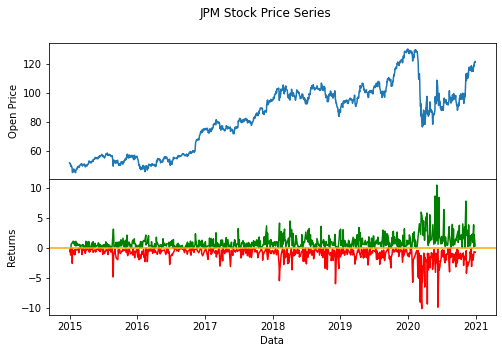

In [51]:
neg = JPM['Rendimenti']>=0
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'][neg==True], color = "green")
axs[1].plot(JPM['Rendimenti'][neg==False], color = "red")
axs[1].axhline(y=0.045864, color = "orange", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()


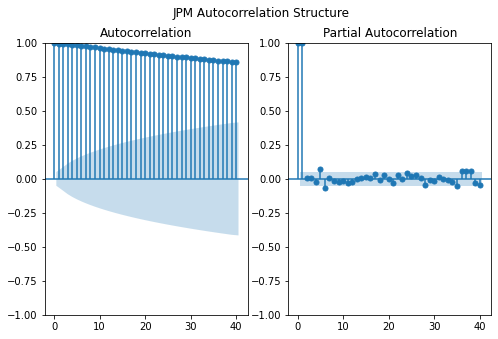

In [50]:
# ACF E PACF di ogni serie; utile anche a capire l'ordine del modello ARIMA
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()

MODELLAZIONE ARIMA



In [43]:
finestra_train=AAPL.index.to_series().between('2019-01-01', '2019-12-31')
finestra_test = AAPL.index.to_series().between('2020-01-01', '2020-01-30')


In [44]:
# AAPL STock Open Price
train = AAPL['Open'][finestra_train]
test = AAPL['Open'][finestra_test]

In [45]:
modello_AAPL = ARIMA(train, order = (2,1,0)).fit()
modello_AAPL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  252
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -272.079
Date:                Sun, 19 Jun 2022   AIC                            550.158
Time:                        14:45:15   BIC                            560.734
Sample:                             0   HQIC                           554.414
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0418      0.066      0.631      0.528      -0.088       0.172
ar.L2          0.0005      0.065      0.008      0.994      -0.128       0.129
sigma2         0.5117      0.036     14.239      0.000       0.441       0.582
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                37.16
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.37
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 30.792342834223025


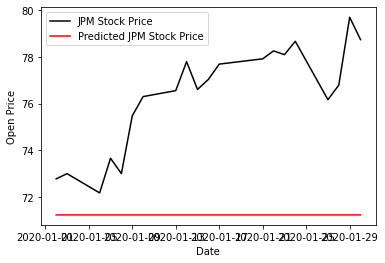

In [46]:
# MSE
yhat_AAPL = modello_AAPL.forecast(steps=20)
MSE_AAPL=mean_squared_error(test, yhat_AAPL)
print("MSE:",MSE_AAPL)
yhat_AAPL.index = test.index
plt.plot(test, color = "black", label = "JPM Stock Price")
plt.plot(yhat_AAPL, color = "red", label = "Predicted JPM Stock Price")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

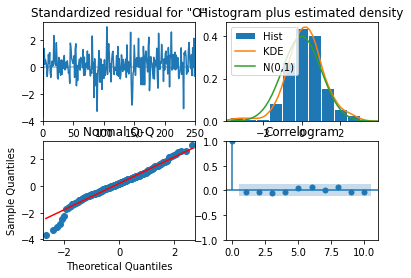

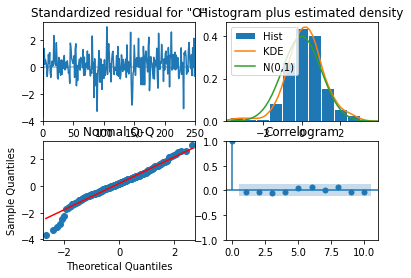

In [47]:
modello_AAPL.plot_diagnostics()

In [48]:
# HD Stock Open price
train = JPM['Open'][finestra_train]
test = JPM['Open'][finestra_test]
modello_JPM = ARIMA(train, order = (1,1,1)).fit()
modello_JPM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -396.875
Date:                Sun, 19 Jun 2022   AIC                            799.751
Time:                        14:45:48   BIC                            810.327
Sample:                             0   HQIC                           804.007
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6620      0.407      1.628      0.103      -0.135       1.459
ma.L1         -0.5906      0.438     -1.349      0.177      -1.449       0.267
sigma2         1.3832      0.114     12.105      0.000       1.159       1.607
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.78   Prob(JB):                         0.41
Heteroskedasticity (H):               1.13   Skew:                             0.15
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

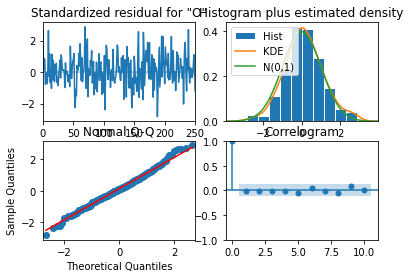

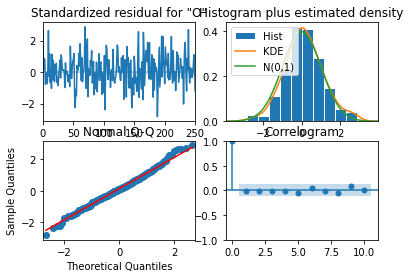

In [26]:
modello_JPM.plot_diagnostics()

5.19187725493122


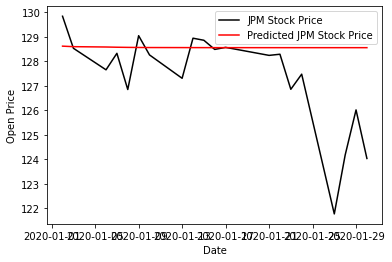

In [49]:
yhat_JPM = modello_JPM.forecast(steps=20)
MSE_JPM=mean_squared_error(test, yhat_JPM)
print(MSE_JPM)
yhat_JPM.index = test.index
plt.plot(test, color = "black", label = "JPM Stock Price")
plt.plot(yhat_JPM, color = "red", label = "Predicted JPM Stock Price")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10'],
              dtype='datetime64[ns]', name='Date', freq=None)

CONVOLUTIONAL NEURAL NETWORK

In [3]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2015-01-01',end='2020-12-31')
filter_row = JPM.index.to_series().between('2015-01-01', '2019-12-31')
test = JPM[filter_row == False]
train = JPM[filter_row==True]
#check for train set
print(train.shape)
train.head()

(1258, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02,50.950395,51.589527,50.860260,51.204411,12600000,0.4,0
2015-01-05,50.852071,51.032337,49.352565,49.614773,20100600,0.0,0
2015-01-06,49.688515,49.778649,47.812084,48.328308,29074100,0.0,0
2015-01-07,49.073975,49.073975,48.074303,48.402065,23843200,0.0,0
2015-01-08,49.139526,49.901570,49.139526,49.483673,16971100,0.0,0


In [4]:
# check for test set
test.head() # eliminiamo il valore del 2014
test = test.drop(test.index[0])
print(test.shape)
test.head()

(252, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02,129.840513,131.057286,129.348236,131.047989,10803700,0.0,0
2020-01-03,128.533385,130.150564,128.140775,129.318604,10386800,0.9,0
2020-01-06,127.654695,129.253189,127.598610,129.215790,10259000,0.0,0
2020-01-07,128.327741,128.869920,126.962958,127.019043,10531300,0.0,0
2020-01-08,126.850791,128.608198,126.757320,128.009933,9695300,0.0,0


In [20]:
y_train, X_train = train['Open'], train.drop('Open', axis=1)
X_test, y_test = test.drop('Open', axis=1), test['Open']

In [21]:
mc = MinMaxScaler(feature_range=(0,1))
X_train[['High','Low','Close', 'Volume','Dividends','Stock Splits']]= mc.fit_transform(X_train[['High','Low','Close', 'Volume','Dividends','Stock Splits']].values)
X_test[['High','Low','Close', 'Volume', 'Dividends','Stock Splits']]=mc.fit_transform(X_test[['High','Low','Close', 'Volume', 'Dividends','Stock Splits']].values)

In [22]:
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0],6,1)


In [43]:
def to_supervised(train, n_input, n_out=5):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], 1))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [23]:
model = keras.Sequential(
    [
     keras.Input(shape=(6,1)),
     layers.Conv1D(64, kernel_size = 2, activation='relu'),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(1, activation = "relu")
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 64)             192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
____________________________________________________

In [24]:
earlyStop = keras.callbacks.EarlyStopping(patience=2)

In [25]:
batch_size = 4
epochs = 20
model.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[[keras.metrics.RootMeanSquaredError()]])
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
283/283 [==============================] - 2s 3ms/step - loss: 2564.3867 - root_mean_squared_error: 50.6398 - val_loss: 58.5562 - val_root_mean_squared_error: 7.6522
Epoch 2/20
283/283 [==============================] - 1s 3ms/step - loss: 20.5656 - root_mean_squared_error: 4.5349 - val_loss: 22.4726 - val_root_mean_squared_error: 4.7405
Epoch 3/20
283/283 [==============================] - 1s 4ms/step - loss: 12.2210 - root_mean_squared_error: 3.4959 - val_loss: 6.6123 - val_root_mean_squared_error: 2.5714
Epoch 4/20
283/283 [==============================] - 1s 3ms/step - loss: 8.3400 - root_mean_squared_error: 2.8879 - val_loss: 3.1830 - val_root_mean_squared_error: 1.7841
Epoch 5/20
283/283 [==============================] - 1s 3ms/step - loss: 6.0523 - root_mean_squared_error: 2.4601 - val_loss: 1.8586 - val_root_mean_squared_error: 1.3633
Epoch 6/20
283/283 [==============================] - 1s 3ms/step - loss: 4.1706 - root_mean_squared_error: 2.0422 - val_loss: 1.511

In [26]:
# valutazione previsiva per la prima settimana out-of-sample
X_test=np.array(X_test)
score= model.evaluate(X_test[2:6],y_test[2:6])

1/1 [==============================] - 0s 161ms/step - loss: 5.7032 - root_mean_squared_error: 2.3881


In [13]:
checkpoint = keras.callbacks.ModelCheckpoint("E:/Laurea Magistrale/Artificial intelligence and deep learning/Esame/Checkpoints.h5",save_best_only=True, save_weights_only=True, monitor="val_MSE" )

In [46]:
def walk_forward_fitting_procedure(X_test, y_test, n_input):
    #X, y = list(), list()
    in_start = 0
    for _ in range(len(train)):
        in_end = in_start + n_input
        out_end = in_end + n_input
        if out_end <= len(test):
           newX_train = X_test[in_end:out_end]
           newy_train = y_test[in_end:out_end]
           model.fit(newX_train, newy_train)
           X_test=X_test.drop(X_test.index[0:5])
           y_test=y_test.drop(y_test.index[0:5])
           score = model.evaluate(X_test, y_test)
    return score 

In [47]:
score = walk_forward_fitting_procedure(X_test=X_test, y_test=y_test,n_input=5)

1/1 [==============================] - 0s 41ms/step - loss: 21.0359 - MSE: 21.0359


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.